In [1]:
import os
import sys
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_validate
from warnings import filterwarnings

sys.path.append('../')
from utils import utils

%matplotlib inline
plt.style.use('ggplot')
filterwarnings('ignore')

In [2]:
# Download the file if it is not present
if not os.path.exists('../data/wages.txt'):
    urlretrieve('http://lib.stat.cmu.edu/datasets/CPS_85_Wages', '../data/wages.txt')

# Give names to the columns
names = [
    'EDUCATION: Number of years of education',
    'SOUTH: 1=Person lives in South, 0=Person lives elsewhere',
    'SEX: 1=Female, 0=Male',
    'EXPERIENCE: Number of years of work experience',
    'UNION: 1=Union member, 0=Not union member',
    'WAGE: Wage (dollars per hour)',
    'AGE: years',
    'RACE: 1=Other, 2=Hispanic, 3=White',
    'OCCUPATION: 1=Management, 2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other',
    'SECTOR: 0=Other, 1=Manufacturing, 2=Construction',
    'MARR: 0=Unmarried,  1=Married',
]
# Get short names
short_names = [n.split(':')[0] for n in names]
# Read the data
data = pd.read_csv('../data/wages.txt', skiprows=27, skipfooter=6, sep=None, header=None)
data.columns = short_names

# Log-transform the wages, as they typically increase with multiplicative factors
data['WAGE'] = np.log10(data['WAGE'])

In [3]:
data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,0,1,21,0,0.707570,35,2,6,1,1
1,9,0,1,42,0,0.694605,57,3,6,1,1
2,12,0,0,1,0,0.824126,19,3,6,1,0
3,12,0,0,4,0,0.602060,22,3,6,0,0
4,12,0,0,17,0,0.875061,35,3,6,0,1


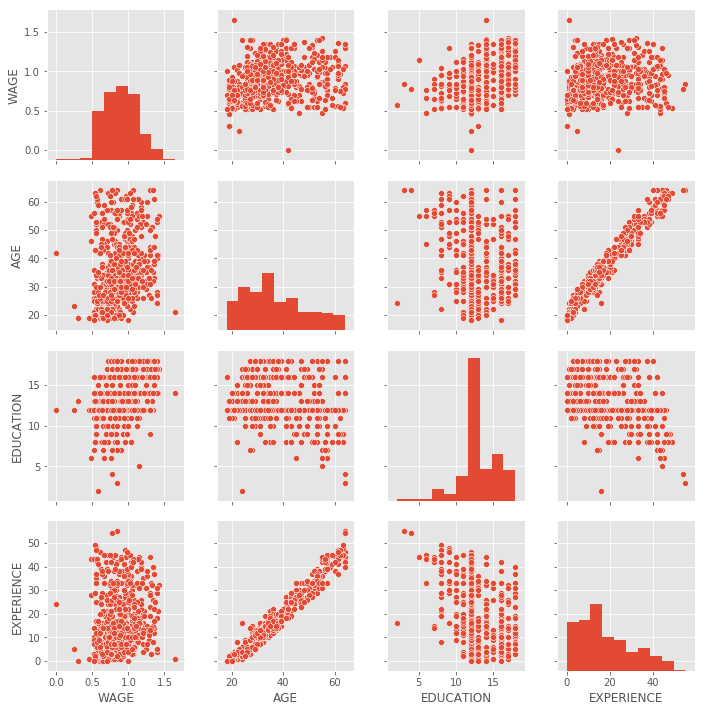

In [4]:
sns.pairplot(data, vars=['WAGE', 'AGE', 'EDUCATION', 'EXPERIENCE']);

Looks like there is almost a perfect correlation between AGE and EXPERIENCE which is common sense.

Also, linear model compute conditional links and marginal links. Therefore, in case when we have highly correlated features (multicollinearity), this is very bad.

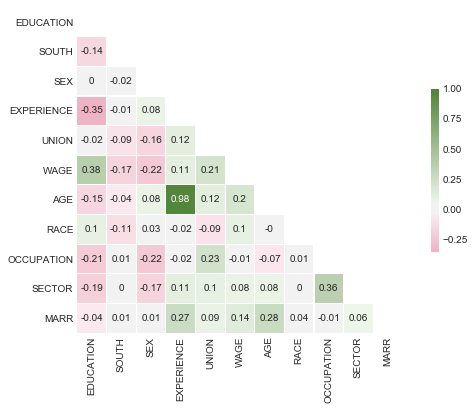

In [5]:
utils.plot_corr_matrix(data)

In [6]:
features = [feature for feature in short_names if feature != 'WAGE']
X = data.loc[:, features].values
y = data.WAGE.values
X.shape, y.shape

((534, 10), (534,))

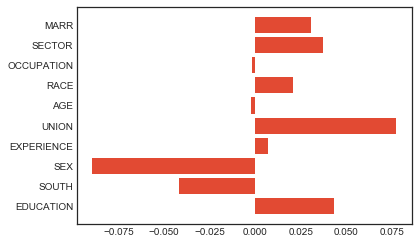

In [7]:
# Build ridge regression and plot its coefficients
ridge_model = RidgeCV()
ridge_model.fit(X, y)
coeffs = ridge_model.coef_

plt.barh(range(coeffs.size), coeffs)
plt.yticks(range(coeffs.size), features);

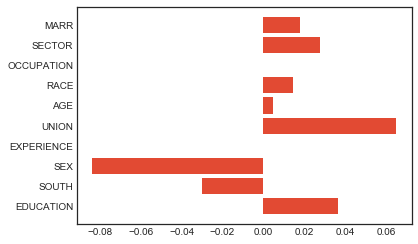

In [8]:
# Build Lasso model
lasso_model = LassoCV()
lasso_model.fit(X, y)
coeffs = lasso_model.coef_

plt.barh(range(coeffs.size), coeffs)
plt.yticks(range(coeffs.size), features);

With lasso, coefficients become actually zero. We also see that EXPERIENCE is 0 but AGE is not even though they are highly correlated. The reason for that is because LASSO select the one that has higher signal-to-noise ratio.

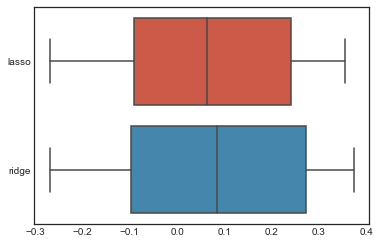

In [9]:
# Use cross validate to get a sense on the stability of the coefficients
cv_ridge = cross_validate(ridge_model, X, y, cv=10)
cv_lasso = cross_validate(lasso_model, X, y, cv=10)
scores = pd.DataFrame({'lasso': cv_lasso['test_score'],
                      'ridge': cv_ridge['test_score']})

# Plot scores on a boxplot
sns.boxplot(data=scores, orient='h');